In [1]:
from astropalmerio.mc import utils
from astropalmerio.mc.sampling import sample_asym_norm
from astropalmerio.mc.realizations import MC_realization
from astropalmerio.mc.MC_var import MC_var
from astropalmerio.mc.utils import unbinned_empirical_cdf, binned_CDFs_from_realizations, quantiles
from astropalmerio.mc.visualization import plot_CDF_with_bounds, plot_ECDF

from astropalmerio.mc.visualization import add_arrows_for_limits

import cmasher as cmr

import time
import logging
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
import sys
from pathlib import Path
log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.INFO,
                    format='%(asctime)s %(levelname)s [%(name)s] %(message)s')
logging.getLogger('matplotlib').setLevel(logging.WARNING)
logging.getLogger('PIL').setLevel(logging.WARNING)
ROOT_DIR = Path('/Users/palmerio/Code_projects/astropalmerio/dev/')
plt.style.use('paper')
plt.style.use('kraken')

## Practical example: propagating the individual measurement uncertainty to the CDF of an observed sample
In the physical sciences, it is often the case that we want to look at the distribution of a certain quantity for various samples, in order to compare them with each other.
How do we then propagate the uncertainty on the measurement of this quantity for each individual object in our sample to the whole sample distribution?
This can be done with Monte Carlo sampling/error propagation, as will be shown below.


For this example, let us assume we are looking at the distribution of stellar masses ($M_*$) of a sample of star-forming galaxies.
We would like to know the uncertainty on the cumulative distribution function of this sample.


## Standard case

2023-03-10 11:05:46,961 INFO [__main__] Starting MC realizations...
2023-03-10 11:05:46,964 INFO [__main__] Finished in 2.29e-03 seconds
2023-03-10 11:05:46,965 INFO [__main__] Starting MC realizations through MC_var class...
2023-03-10 11:05:46,967 INFO [__main__] Finished in 1.74e-03 seconds
2023-03-10 11:05:47,006 INFO [__main__] Plotting individual MC realizations of the CDF...
2023-03-10 11:05:48,402 INFO [__main__] Finished in 1.40e+00 seconds
2023-03-10 11:05:48,403 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-03-10 11:05:48,524 INFO [__main__] Finished in 1.21e-01 seconds
2023-03-10 11:05:48,536 INFO [__main__] Plotting individual PDFs using MC_var class method...
2023-03-10 11:05:52,611 INFO [__main__] Finished in 4.07e+00 seconds
2023-03-10 11:05:52,612 INFO [__main__] Plotting individual realizations histograms using MC_var class method...
2023-03-10 11:05:56,799 INFO [__main__] Finished in 4.19e+00 seconds


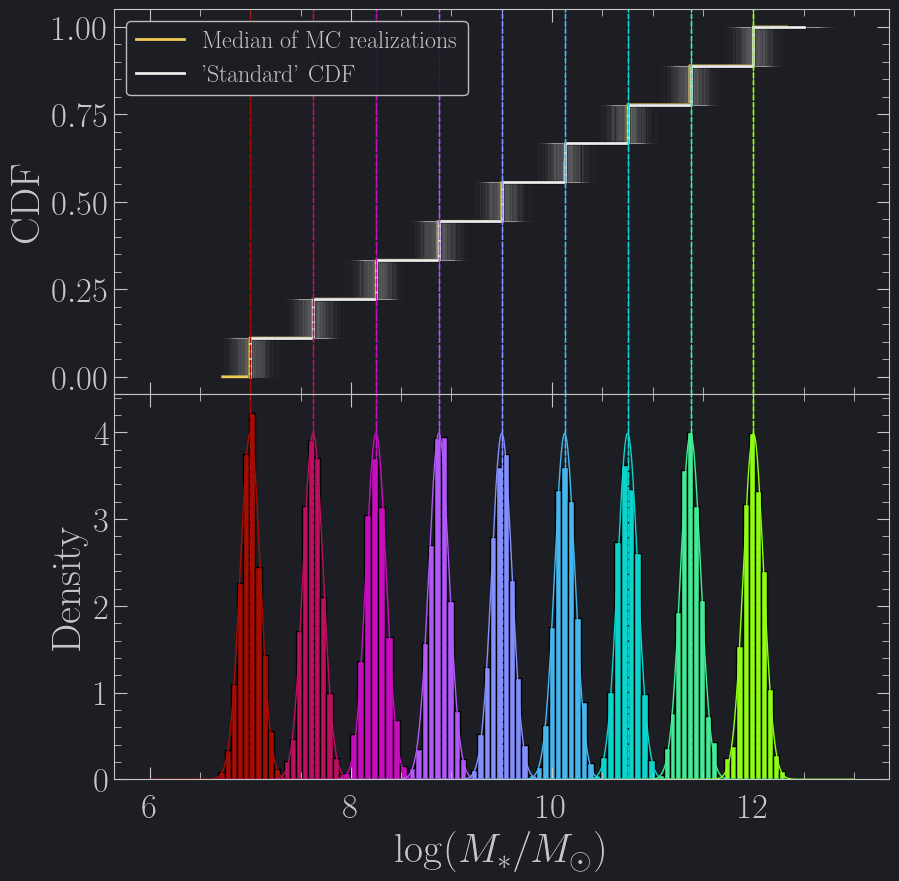

In [2]:
N_MC = 1000    # Number of Monte Carlo realizations
N_gal = 9      # Size of our sample (i.e. number of galaxies)
abs_unc = 0.1  # absolute uncertainty value

logMstar = np.linspace(7, 12, N_gal)
logMstar_unc = abs_unc * np.ones(N_gal)

logging.getLogger('astropalmerio.mc.realizations').setLevel('INFO')

log.info("Starting MC realizations...")
t1 = time.time()
# For use of arrays instead of a single MC variable
logMstar_MC = MC_realization(data=logMstar,
                             uncp=logMstar_unc,
                             N_MC=N_MC)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Starting MC realizations through MC_var class...")
t1 = time.time()
# For ease of use of the plotting methods of the MC_var class
gals = []
for i in range(N_gal):
    gal = MC_var(value=logMstar[i], uncertainty=logMstar_unc[i], N_MC=N_MC)
    gal.sample()
    gals.append(gal)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")
   

colors = cmr.take_cmap_colors('cmr.neon', N_gal, cmap_range=(0.0, 1), return_fmt='hex')

fig, axes = plt.subplots(2,figsize=(10,10), sharex=True)
ax = axes[1]
ax_CDF = axes[0]

# CDFs
log.info("Plotting individual MC realizations of the CDF...")
t1 = time.time()
for i in range(min(N_MC, 1000)):
    plot_ECDF(logMstar_MC[i], ax=ax_CDF, lw=1, color='C12', alpha=0.01)

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Computing and plotting median CDF and its bounds...")
t1 = time.time()
bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
med, upp, low = quantiles(CDFs)
ax_CDF.plot(0.5*(bins[1:]+bins[:-1]), med,
            drawstyle="steps-mid",
            lw=2,
            color='C9',
            label='Median of MC realizations')

# plot_CDF_with_bounds(bins_mid=0.5*(bins[1:]+bins[:-1]),
#                      median=med,
#                      upper=upp,
#                      lower=low,
#                      ax=ax_CDF,
#                      lw=2,
#                      color='C9',
#                      alpha=0.5,
#                      label='Median of MC realizations')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")


# Classical CDF
plot_ECDF(logMstar, ax=ax_CDF, lw=2.5, color='black')
plot_ECDF(logMstar, ax=ax_CDF, lw=2, color='C12', label="'Standard' CDF")

ax_CDF.legend(loc='upper left')

# Individual PDFs
log.info("Plotting individual PDFs using MC_var class method...")
t1 = time.time()
for i, gal in enumerate(gals):
    gal.show_pdf(ax=ax, color=colors[i], lw=1)
    ax.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Plotting individual realizations histograms using MC_var class method...")
t1 = time.time()
for i, gal in enumerate(gals):
    gal.show_realizations(ax=ax, density=True, color=colors[i])
    ax.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

for i, gal in enumerate(gals):
    ax.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])

ax_CDF.set_ylabel('CDF')
ax.set_ylabel('Density')
ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
fig.subplots_adjust(hspace=0)
plt.show()

In [4]:
# fig.savefig('../plots/CDF_standard_example.pdf')

## Case with large errors (30% relative error)

2023-03-10 11:07:54,085 INFO [__main__] Starting MC realizations...
2023-03-10 11:07:54,088 INFO [__main__] Finished in 1.48e-03 seconds
2023-03-10 11:07:54,089 INFO [__main__] Starting MC realizations through MC_var class...
2023-03-10 11:07:54,091 INFO [__main__] Finished in 1.31e-03 seconds
2023-03-10 11:07:54,117 INFO [__main__] Plotting individual MC realizations of the CDF...
2023-03-10 11:07:55,619 INFO [__main__] Finished in 1.50e+00 seconds
2023-03-10 11:07:55,620 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-03-10 11:07:55,746 INFO [__main__] Finished in 1.25e-01 seconds
2023-03-10 11:07:55,759 INFO [__main__] Plotting individual PDFs using MC_var class method...
2023-03-10 11:07:59,976 INFO [__main__] Finished in 4.22e+00 seconds


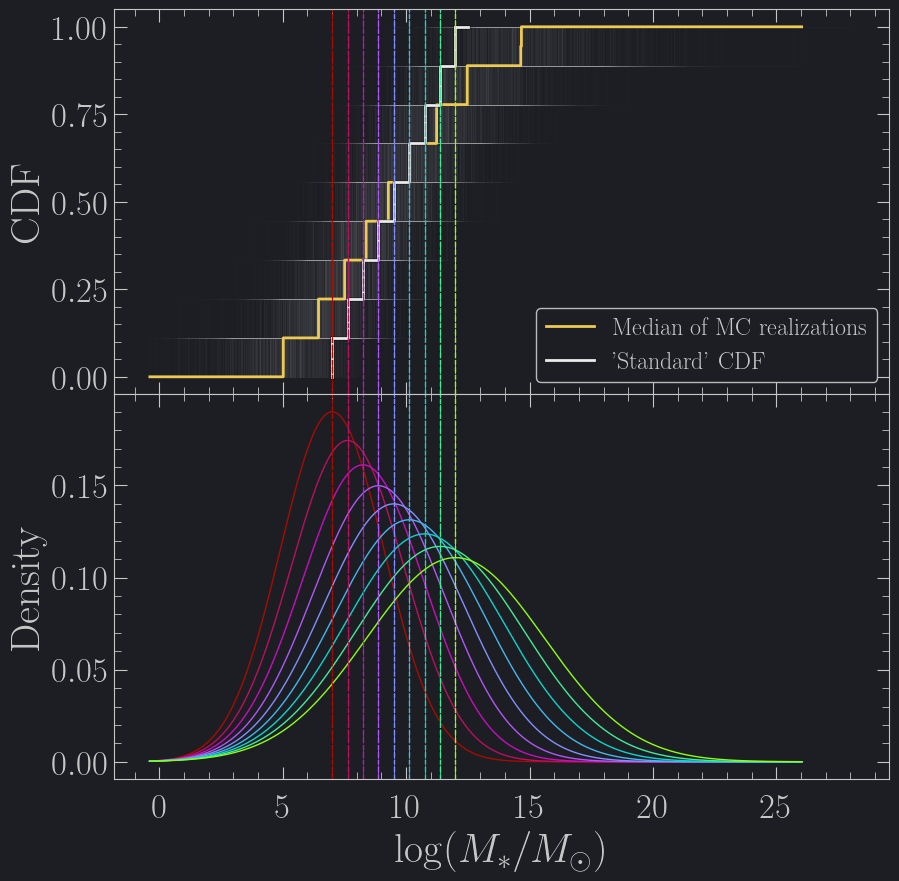

In [7]:
N_MC = 1000    # Number of Monte Carlo realizations
N_gal = 9      # Size of our sample (i.e. number of galaxies)
rel_unc = 0.3  # absolute uncertainty value

logMstar = np.linspace(7, 12, N_gal)
logMstar_unc = rel_unc * logMstar
np.random.seed(0)  # To allow reproducibility

logging.getLogger('astropalmerio.mc.realizations').setLevel('INFO')

log.info("Starting MC realizations...")
t1 = time.time()
# For use of arrays instead of a single MC variable
logMstar_MC = MC_realization(data=logMstar,
                             uncp=logMstar_unc,
                             N_MC=N_MC)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Starting MC realizations through MC_var class...")
t1 = time.time()
# For ease of use of the plotting methods of the MC_var class
gals = []
for i in range(N_gal):
    gal = MC_var(value=logMstar[i], uncertainty=logMstar_unc[i], N_MC=N_MC)
    gal.sample()
    gals.append(gal)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")
   

colors = cmr.take_cmap_colors('cmr.neon', N_gal, cmap_range=(0.0, 1), return_fmt='hex')

fig, axes = plt.subplots(2,figsize=(10,10), sharex=True)
ax = axes[1]
ax_CDF = axes[0]

# CDFs
log.info("Plotting individual MC realizations of the CDF...")
t1 = time.time()
for i in range(min(N_MC, 1000)):
    plot_ECDF(logMstar_MC[i], ax=ax_CDF, lw=1, alpha=0.01, color='C12')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Computing and plotting median CDF and its bounds...")
t1 = time.time()
bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
med, upp, low = quantiles(CDFs)
ax_CDF.plot(0.5*(bins[1:]+bins[:-1]), med,
            drawstyle="steps-mid",
            lw=2,
            color='C9',
            label='Median of MC realizations')
# plot_CDF_with_bounds(bins_mid=0.5*(bins[1:]+bins[:-1]),
#                      median=med,
#                      upper=upp,
#                      lower=low,
#                      ax=ax_CDF,
#                      lw=2,
#                      color='C9',
#                      alpha=0.5,
#                      label='Median of MC realizations')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")


# Classical CDF
plot_ECDF(logMstar, ax=ax_CDF, lw=2.5, color='black')
plot_ECDF(logMstar, ax=ax_CDF, lw=2, color='C12', label="'Standard' CDF")

ax_CDF.legend(loc='lower right')

# Individual PDFs
log.info("Plotting individual PDFs using MC_var class method...")
t1 = time.time()
x = np.linspace(logMstar_MC.min(), logMstar_MC.max(), 1000)
for i, gal in enumerate(gals):
    gal.show_pdf(x=x, ax=ax, color=colors[i], lw=1)
    ax.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=1, color=colors[i])
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

for i, gal in enumerate(gals):
    ax.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])

ax_CDF.set_ylabel('CDF')
ax.set_ylabel('Density')
ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
fig.subplots_adjust(hspace=0)
plt.show()

In [ ]:
# fig.savefig('../plots/CDF_large_error_example.pdf')

## Adding some values with limits

In [8]:
np.random.seed(0)  # To allow reproducibility

N_MC = 1000    # Number of Monte Carlo realizations
N_gal = 9      # Size of our sample (i.e. number of galaxies)

logMstar = np.linspace(7, 12, N_gal)
uplims = np.array([False for i in range(N_gal)])
# assume measurements number 4 and 5 are upper limits
uplims[[3,4]] = True
lolims = np.array([False for i in range(N_gal)])
# assume final measurement is a lower limit
lolims[-1] = True
val_min = np.where(uplims, 5, None)           # minimum value allowed in case of upper limits
val_max = np.where(lolims, 15, None)           # maximum value allowed in case of lower limits
logMstar_unc = np.where(lolims|uplims, None, 0.1 * logMstar)
logMstar_unc

array([0.7000000000000001, 0.7625000000000001, 0.8250000000000001, None,
       None, 1.0125, 1.075, 1.1375, None], dtype=object)

2023-03-10 11:08:40,955 INFO [__main__] Starting MC realizations...
2023-03-10 11:08:40,958 INFO [__main__] Finished in 1.08e-03 seconds
2023-03-10 11:08:40,958 INFO [__main__] Starting MC realizations through MC_var class...
2023-03-10 11:08:40,961 INFO [__main__] Finished in 1.44e-03 seconds
2023-03-10 11:08:40,987 INFO [__main__] Plotting individual MC realizations of the CDF...
2023-03-10 11:08:42,469 INFO [__main__] Finished in 1.48e+00 seconds
2023-03-10 11:08:42,470 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-03-10 11:08:42,594 INFO [__main__] Finished in 1.24e-01 seconds
2023-03-10 11:08:42,605 INFO [__main__] Plotting individual PDFs using MC_var class method...
2023-03-10 11:08:46,646 INFO [__main__] Finished in 4.04e+00 seconds


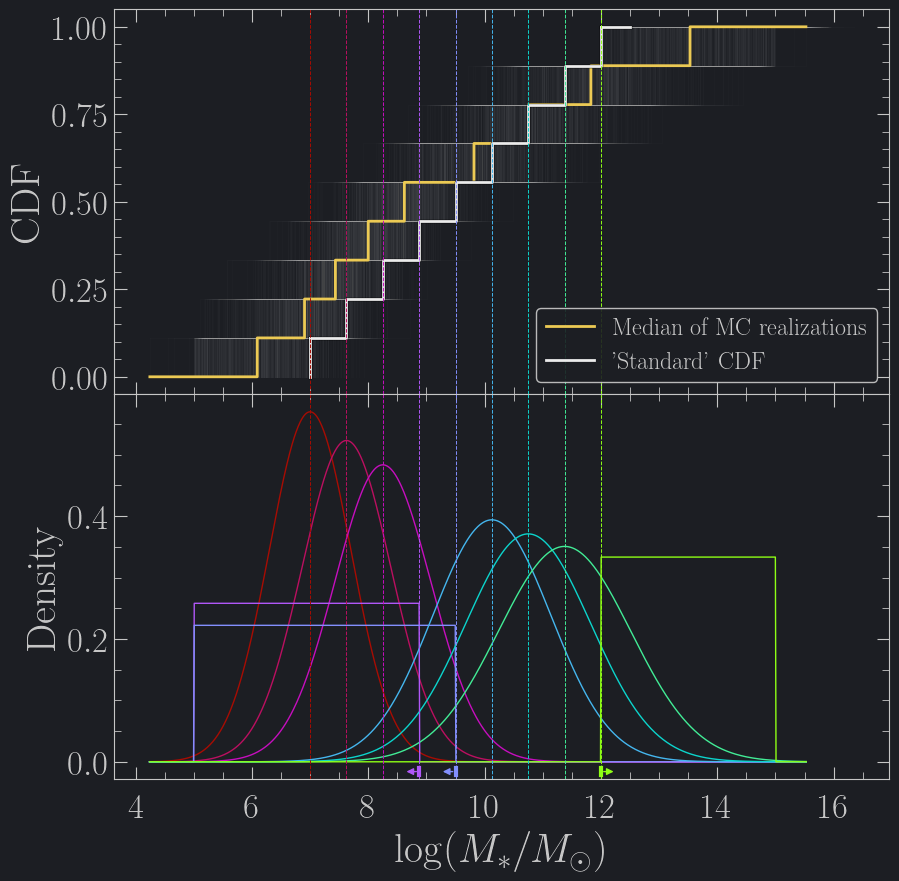

In [9]:
np.random.seed(0)  # To allow reproducibility

logging.getLogger('astropalmerio.mc.visualization').setLevel('DEBUG')

log.info("Starting MC realizations...")
t1 = time.time()
# For use of arrays instead of a single MC variable
logMstar_MC = MC_realization(data=logMstar,
                             uncp=logMstar_unc,
                             uplim=uplims,
                             lolim=lolims,
                             val_max=val_max,
                             val_min=val_min,
                             N_MC=N_MC)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Starting MC realizations through MC_var class...")
t1 = time.time()
# For ease of use of the plotting methods of the MC_var class
gals = []
for i in range(N_gal):
    gal = MC_var(value=logMstar[i],
                 uncertainty=logMstar_unc[i],
                 uplim=uplims[i],
                 val_min=val_min[i],
                 lolim=lolims[i],
                 val_max=val_max[i],
                 N_MC=N_MC)
    gal.sample()
    gals.append(gal)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")
   

colors = cmr.take_cmap_colors('cmr.neon', N_gal, cmap_range=(0.0, 1), return_fmt='hex')

fig, axes = plt.subplots(2,figsize=(10,10), sharex=True)
ax = axes[1]
ax_CDF = axes[0]

# CDFs
log.info("Plotting individual MC realizations of the CDF...")
t1 = time.time()
for i in range(min(N_MC, 1000)):
    plot_ECDF(logMstar_MC[i], ax=ax_CDF, lw=1, alpha=0.01, color='C12')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

log.info("Computing and plotting median CDF and its bounds...")
t1 = time.time()
bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
med, upp, low = quantiles(CDFs)
ax_CDF.plot(0.5*(bins[1:]+bins[:-1]), med,
            drawstyle="steps-mid",
            lw=2,
            color='C9',
            label='Median of MC realizations')

t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")


# Classical CDF
plot_ECDF(logMstar, ax=ax_CDF, lw=2.5, color='black')
plot_ECDF(logMstar, ax=ax_CDF, lw=2, color='C12', label="'Standard' CDF")

ax_CDF.legend(loc='lower right')

# Individual PDFs
log.info("Plotting individual PDFs using MC_var class method...")
t1 = time.time()
x = np.linspace(logMstar_MC.min(), logMstar_MC.max(), 1000)
for i, gal in enumerate(gals):
    gal.show_pdf(x=x, ax=ax, color=colors[i], lw=1)
t2 = time.time()
log.info(f"Finished in {t2-t1:.2e} seconds")

for i, gal in enumerate(gals):
    ax.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    ax_CDF.axvline(logMstar[i], ls='--', lw=0.7, color=colors[i])
    if gal.lim['upper']:
        add_arrows_for_limits(logMstar[i], lim_type='upper', ax=ax, logscale=False, color=colors[i])    
    elif gal.lim['lower']:
        add_arrows_for_limits(logMstar[i], lim_type='lower', ax=ax, logscale=False, color=colors[i])    

# ax.set_xscale('log')
ax_CDF.set_ylabel('CDF')
ax.set_ylabel('Density')
ax.set_xlabel(r'$\log(M_*/M_{\odot})$')
fig.subplots_adjust(hspace=0)
plt.show()

In [10]:
# fig.savefig('../plots/CDF_with_limits_example.pdf')

## Impact of sample size versus error size

2023-03-10 11:09:05,709 INFO [__main__] Starting MC realizations for N_gal=9...
2023-03-10 11:09:05,713 INFO [__main__] Finished in 2.84e-03 seconds
2023-03-10 11:09:05,713 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-03-10 11:09:07,125 INFO [__main__] Finished in 1.41e+00 seconds
2023-03-10 11:09:07,132 INFO [__main__] Starting MC realizations for N_gal=90...
2023-03-10 11:09:07,156 INFO [__main__] Finished in 2.27e-02 seconds
2023-03-10 11:09:07,156 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-03-10 11:09:08,385 INFO [__main__] Finished in 1.23e+00 seconds
2023-03-10 11:09:08,389 INFO [__main__] Starting MC realizations for N_gal=900...
2023-03-10 11:09:08,618 INFO [__main__] Finished in 2.29e-01 seconds
2023-03-10 11:09:08,619 INFO [__main__] Computing and plotting median CDF and its bounds...
2023-03-10 11:09:10,822 INFO [__main__] Finished in 2.20e+00 seconds
2023-03-10 11:09:10,828 INFO [__main__] Starting MC realizations fo

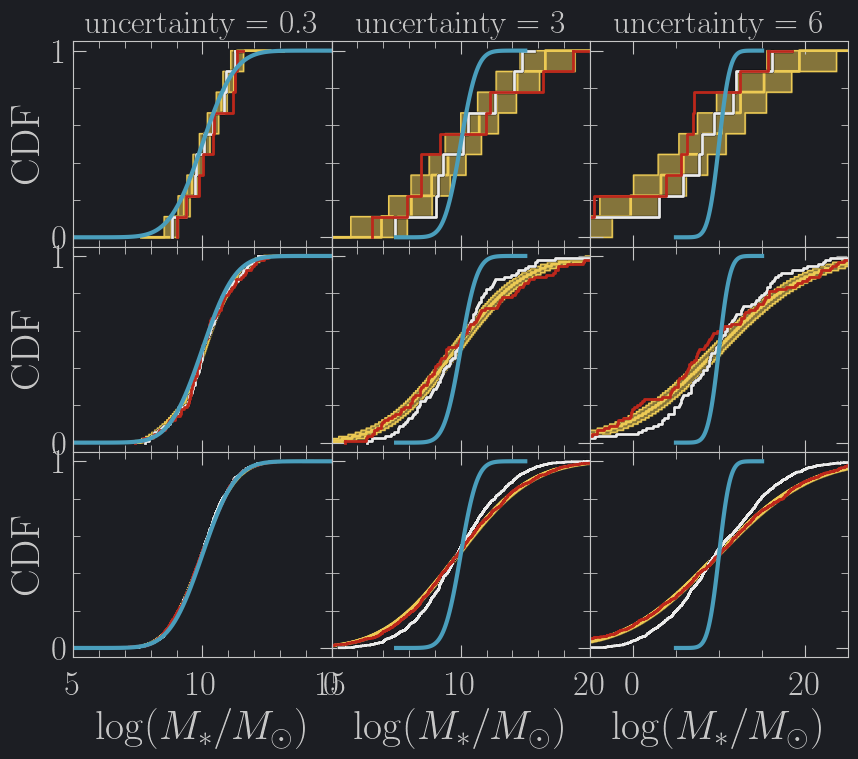

In [11]:
np.random.seed(10)  # To allow reproducibility

N_MC = 10000    # Number of Monte Carlo realizations
N_gals = [9, 90, 900]      
uncs = [0.3, 3, 6]
fig, axes = plt.subplots(len(N_gals), len(uncs), sharex='col')

for i in range(len(uncs)):
    for ax, N_gal in zip(axes.T[i], N_gals):
        # Draw the values from a gaussian distribution
        logMstar = np.random.normal(10, 1, N_gal)
        # Add some random uncertainty
        logMstar = logMstar + np.random.normal(0, uncs[i], N_gal)
        logMstar_unc = uncs[i] * np.ones(len(logMstar))

        log.info(f"Starting MC realizations for {N_gal=}...")
        t1 = time.time()
        # For use of arrays instead of a single MC variable
        logMstar_MC = MC_realization(data=logMstar,
                                     uncp=logMstar_unc,
                                     N_MC=N_MC)

        logMstar_true = logMstar_MC[0]

        t2 = time.time()
        log.info(f"Finished in {t2-t1:.2e} seconds")

        log.info("Computing and plotting median CDF and its bounds...")
        t1 = time.time()
        bins, CDFs = binned_CDFs_from_realizations(logMstar_MC)
        med, upp, low = quantiles(CDFs)
        plot_CDF_with_bounds(bins_mid=0.5*(bins[1:]+bins[:-1]),
                             median=med,
                             upper=upp,
                             lower=low,
                             ax=ax,
                             lw=2,
                             color='C9',
                             alpha=0.5,
                             label='Median of MC realizations')
        t2 = time.time()
        log.info(f"Finished in {t2-t1:.2e} seconds")

        # Classical CDF
        plot_ECDF(logMstar, ax=ax, lw=2.5, color='black')
        plot_ECDF(logMstar, ax=ax, lw=2, color='C12', label="'Standard' CDF")
        plot_ECDF(logMstar_true, ax=ax, lw=2, color='C4')
        
        # True CDF
        x = np.linspace(5, 15, 100)
        ax.plot(x, norm.cdf(x, 10, 1), color='C0')

    axes[i,0].set_ylabel('CDF')
    axes[0,i].set_title(f'uncertainty = {uncs[i]}')
    axes[-1,i].set_xlabel(r'$\log(M_*/M_{\odot})$')

for i, ax in enumerate(axes[:,1:].flatten()):
    ax.tick_params(axis='y',labelleft=False)

axes[0,0].set_xlim(5,15)
axes[0,1].set_xlim(0,20)
axes[0,2].set_xlim(-5,25)
    
# axes[-1,-1].legend(loc='lower right')
fig.subplots_adjust(hspace=0, wspace=0)

plt.show()